In [87]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.io as pio
from IPython.display import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import warnings
from funcs import *
from collections import Counter
import re
import pycountry
import geotext
import string
import geopandas as gpd
warnings.filterwarnings('ignore')

## General Statistics

In this section, I load the data and exctract general information about it. This general information are: 
- size of the dataset - name of the columns - dtype of the columns - number and percentage of missing values 
- number and percentage of unique values for each column

This helps with the data cleaning process

In [2]:
# reading the companies_sorted csv file
df = pd.read_csv("companies_sorted.csv")
df.head(5)

,Unnamed: 0,name,domain,year founded,industry,size range,locality,country,linkedin url,current employee estimate,total employee estimate
0,5872184,ibm,ibm.com,1911.0,information technology and services,10001+,"new york, new york, united states",united states,linkedin.com/company/ibm,274047,716906
1,4425416,tata consultancy services,tcs.com,1968.0,information technology and services,10001+,"bombay, maharashtra, india",india,linkedin.com/company/tata-consultancy-services,190771,341369
2,21074,accenture,accenture.com,1989.0,information technology and services,10001+,"dublin, dublin, ireland",ireland,linkedin.com/company/accenture,190689,455768
3,2309813,us army,goarmy.com,1800.0,military,10001+,"alexandria, virginia, united states",united states,linkedin.com/company/us-army,162163,445958
4,1558607,ey,ey.com,1989.0,accounting,10001+,"london, greater london, united kingdom",united kingdom,linkedin.com/company/ernstandyoung,158363,428960


In [3]:
print(f'Columns: {[col for col in df.columns]}')
print(f'Number of data points: {df.size}')

Columns: ['Unnamed: 0', 'name', 'domain', 'year founded', 'industry', 'size range', 'locality', 'country', 'linkedin url', 'current employee estimate', 'total employee estimate']
Number of data points: 78907686


In [4]:
df_overview = DataOverview(df)
df_overview.overview()

,Column,Count,Missing_value_count,Missing_value_percentage,Unique_value_count,Unique_value_percentage,Dtype
0,Unnamed: 0,7173426,0,0.0%,7173426,100.0%,int64
1,name,7173423,3,0.0%,7004634,97.65%,object
2,domain,5522805,1650621,23.01%,5474764,76.32%,object
3,year founded,3566446,3606980,50.28%,234,0.0%,float64
4,industry,6883423,290003,4.04%,148,0.0%,object
5,size range,7173426,0,0.0%,8,0.0%,object
6,locality,4664601,2508825,34.97%,96244,1.34%,object
7,country,4824219,2349207,32.75%,236,0.0%,object
8,linkedin url,7173426,0,0.0%,7173426,100.0%,object
9,current employee estimate,7173426,0,0.0%,5379,0.07%,int64


In the above table, we can see the number of missing and unique values in each column. We can gain some insights from this analysis.
- The column 'Unnamed' doesn't containt any useful information and we can remove it.
- There are columns with missing values. Since name and industry are the necessary one, we remove the rows with missing values in those two.
- There are repetative names in the dataset (97.65%), which should be removed for furthur analysis.
- The data type for 'year founded' column is float. We should convert it to integer.
- The object types needs to be converted to string to assist furthur analysis.

In [5]:
# removing 'Unnamed' columns
df.drop(columns=['Unnamed: 0'], inplace=True)
# removing rows with missing values in either name or industry
df.drop(df.index[df.name.isna()], inplace=True)
df.drop(df.index[df.industry.isna()], inplace=True)
# converting object dtype to string
string_columns = df.select_dtypes(include='object').columns.tolist()
convert_to_str(df, string_columns)
# converting dtype of 'year founded' from float to integer
df['year founded'].fillna(0, inplace=True)
df['year founded'] = df['year founded'].astype('int64')
# removing repeated rows (considering all columns)
remove_duplicates(df)

No duplicate rows found.


## Univariate Analysis

In this section, I analyze each variable separately.

### Name

Here, I analyze the name column. 

- First, I examine how many unique name do we have. After that, I'll drop the rows with repeated names. The reason is that the name of the company is the identifying feature of the companies and if rows with companies with the same name but different features exists, it will make furthur analysis inaccurate.

- Second, I examine the number of names that contain non-English alphabet, non-ASCII characters, and digits.
- Third, the common words in the compnay names is examined and analyzed.

In [6]:
counts_df = df.groupby('name').size().reset_index(name='count').sort_values('count', ascending=False)\
            .reset_index(inplace=False, drop=True)

counts_df

,name,count
0,independent consultant,63
1,private practice,53
2,consultant,53
3,independent,49
4,independent contractor,40
...,...,...
6728512,follow spot productions,1
6728513,follow rover,1
6728514,follow productions,1
6728515,follow prod,1


In [7]:
# Select repeated names
repeated_names = counts_df.query('count > 1').name.tolist()
# Droping companies with similar names
df = df[~df.name.isin(repeated_names)]
df.reset_index(inplace=True, drop=True)

In [8]:
# Filtering names with a character that is not an English alphabet or space
percentage_non_alpha = check_percentage(df, r'[^a-zA-Z\s]')
print(f"Percentage of names containing non-english alphabet characters: {percentage_non_alpha}%")

# Filtering names with non-ascii characters, here I considered the standard ascii characters 
percentage_non_ascii = check_percentage(df, r'[^\x00-\x7f]')
print(f"Percentage of names containing non-ASCII characters: {percentage_non_ascii}%")

# Filtering names with digits
percentage_digits = check_percentage(df, r'[0-9]')
print(f"Percentage of names containing digits: {percentage_digits}%")

Percentage of names containing non-english alphabet characters: 31.36%
Percentage of names containing non-ASCII characters: 4.34%
Percentage of names containing digits: 2.68%


In [29]:
# Create a list of all words in the company names
all_words = [word.replace('.', '') for name in df['name'] for word in name.split() if len(word) > 1]
# Count the occurrences of each word
word_counts = Counter(all_words)
# Find the 5 most common words and their counts
most_common_words = word_counts.most_common(10)
print("The 10 most common words in company names are:")
for word, count in most_common_words:
    word_in_names = df['name'].apply(lambda name: word in [w.replace('.', '') for w in name.split() if len(w)>1])
    percentage = word_in_names.sum() / len(df) * 100
    print(f"'{word}': {count} occurrences, present in {round(percentage, 2)}% of names")

The 10 most common words in company names are:
'inc': 437700 occurrences, present in 6.63% of names
'ltd': 384705 occurrences, present in 5.83% of names
'llc': 247491 occurrences, present in 3.75% of names
'limited': 225791 occurrences, present in 3.42% of names
'the': 169339 occurrences, present in 2.54% of names
'group': 156242 occurrences, present in 2.37% of names
'of': 147526 occurrences, present in 2.17% of names
'services': 126486 occurrences, present in 1.91% of names
'and': 117865 occurrences, present in 1.77% of names
'solutions': 115716 occurrences, present in 1.75% of names


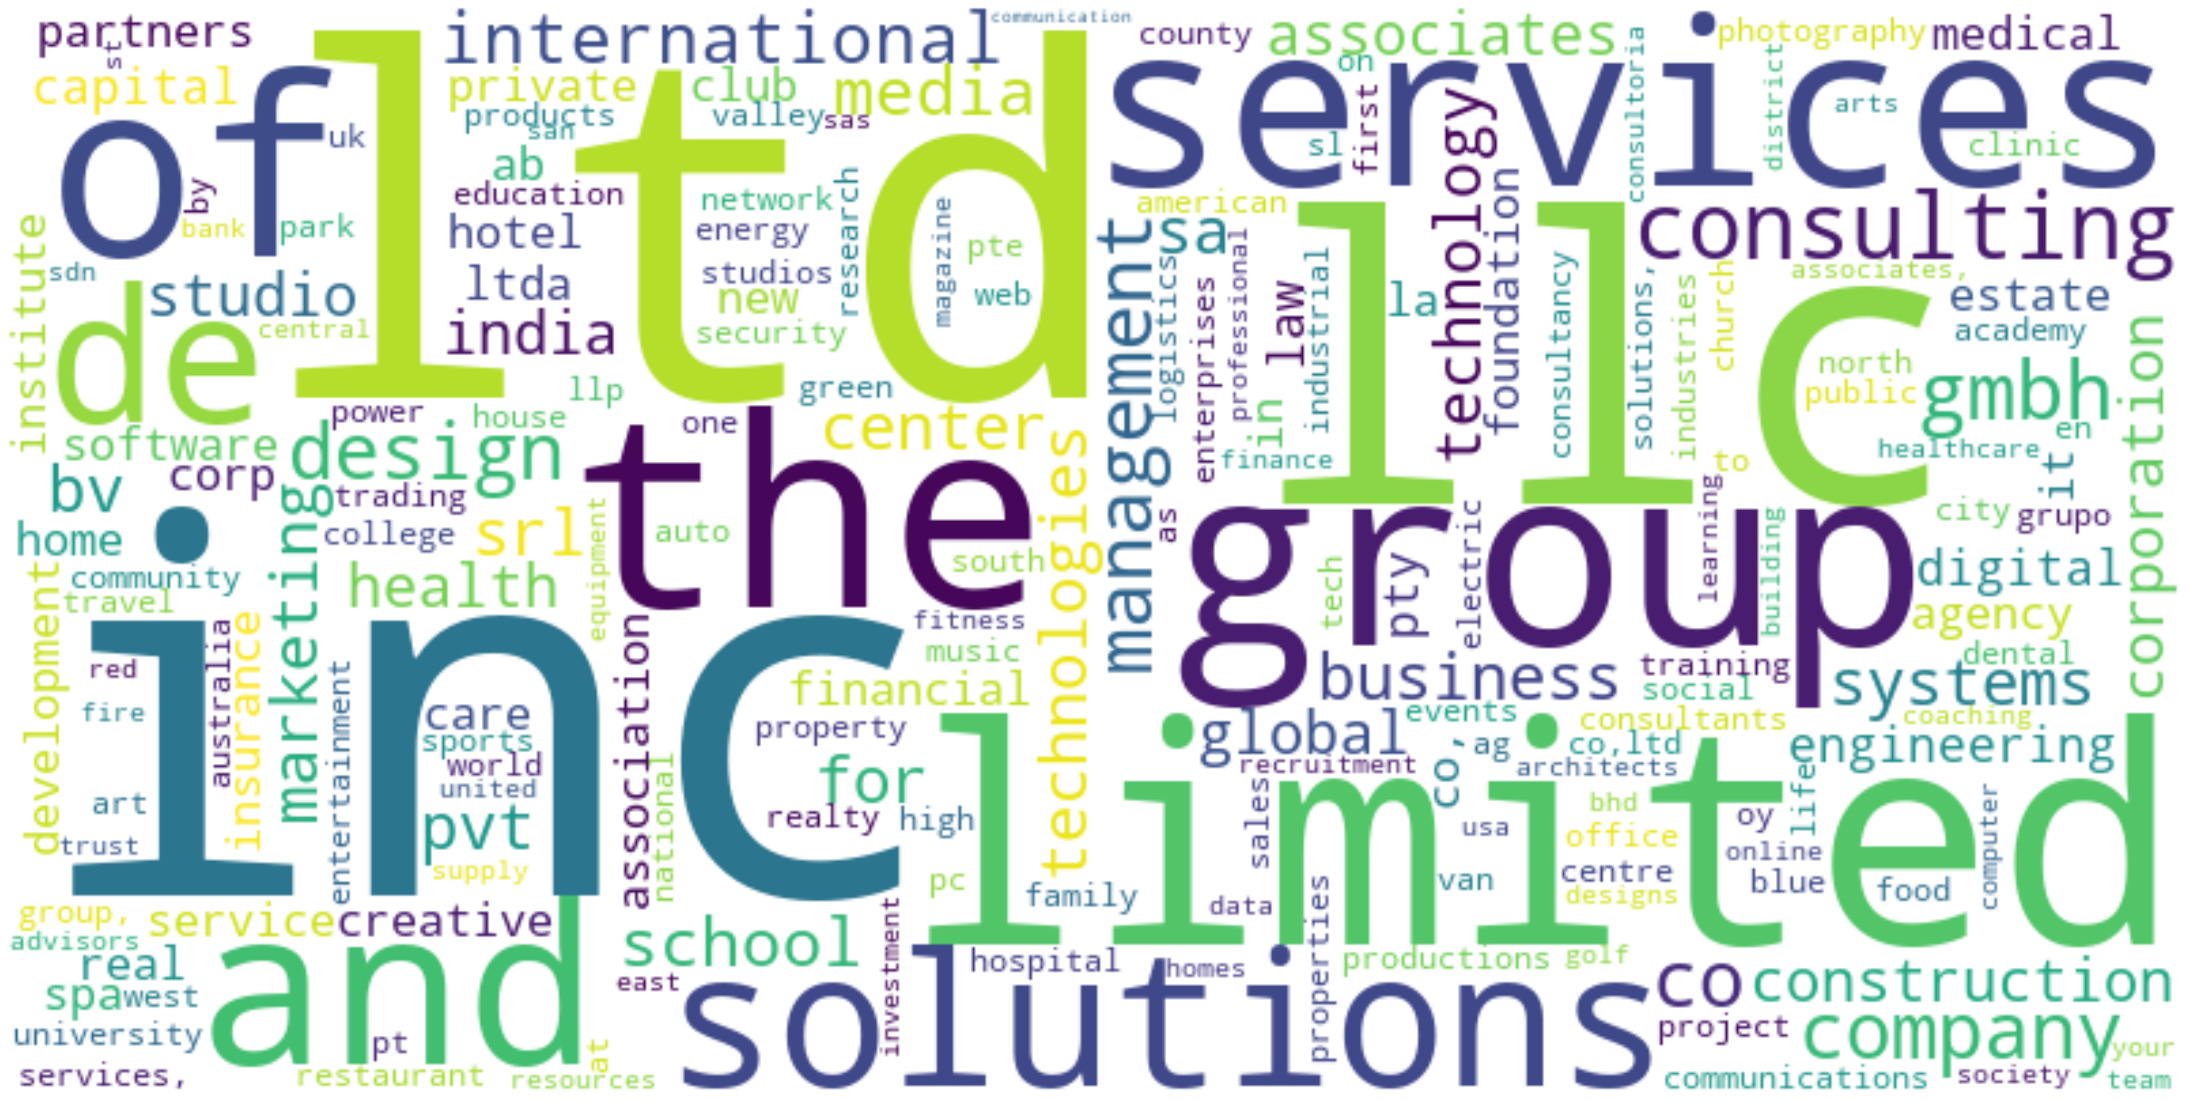

In [30]:
common_words = word_counts.most_common(500)
# Generate the word cloud using frequencies
wordcloud_img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(dict(common_words))

# Display the word cloud
fig, ax = plt.subplots(figsize=(40, 20))
ax.imshow(wordcloud_img, interpolation='bilinear')
ax.axis('off')  # Hide the axis
plt.show()

In [46]:
# Create a list of all country names
countries = [country.name.lower() for country in pycountry.countries]

# Define a function to check if a company name contains a country
def contains_country(name):
    words = [word.replace('.', '') for word in name.split() if len(word) > 1]
    return any(country in name for country in countries)

# Apply this function to the 'name' column and sum the result to get the number of names containing a country
num_names_with_country = df['name'].apply(contains_country).sum()
percentage = num_names_with_country.sum() / len(df) * 100
print(f"There are {num_names_with_country} company names ({round(percentage, 2)}%) that contain a country name.")

There are 191720 company names (2.91%) that contain a country name.


- From the above analysis, we can see that most common words in companies names are: inc, ltd, llc, limited, the, and group, which are related to company's structure (ignoring the 'the')
- We can also see some company names contain a country name (2.91%)

### Domain

In [47]:
# unique value counts
counts_df = df['domain'].value_counts().rename_axis('domain').reset_index(name='count')
counts_df

,domain,count
0,nordalps.com,12
1,play-cricket.com,8
2,dunked.com,8
3,virtualcu.net,8
4,pradocapitalgroup.com,7
...,...,...
5177965,tsizzle55.com,1
5177966,infernoentertainment.co.uk,1
5177967,teddyexpressworkshop.co.uk,1
5177968,calceramdentallab.com,1


In [48]:
df[df['domain'] == 'dunked.com']

,name,domain,year founded,industry,size range,locality,country,linkedin url,current employee estimate,total employee estimate
3109560,"alex mitchell studios, llc",dunked.com,2003,design,1 - 10,"atlanta, georgia, united states",united states,linkedin.com/company/alex-mitchell-studios-llc,1,1
3279463,nomad design associates,dunked.com,2017,design,1 - 10,"london, greater london, united kingdom",united kingdom,linkedin.com/company/nomad-design-associates,1,1
3546675,m.cascaes design gráfico,dunked.com,2005,graphic design,1 - 10,<NA>,brazil,linkedin.com/company/m.cascaes-design-gr-fico,1,1
3728117,totdetweede,dunked.com,2010,graphic design,1 - 10,"bergambacht, south holland, netherlands",netherlands,linkedin.com/company/totdetweede,1,1
3793651,creative inkling,dunked.com,2017,design,1 - 10,"godalming, surrey, united kingdom",united kingdom,linkedin.com/company/creative-inkling,1,1
4171060,amber llovet design,dunked.com,0,design,1 - 10,<NA>,<NA>,linkedin.com/company/amber-llovet,1,1
4260932,rjs design,dunked.com,0,design,1 - 10,"lansdale, pennsylvania, united states",united states,linkedin.com/company/rjsdesign,1,1
4859042,all rounder,dunked.com,2010,animation,1 - 10,"barcelona, catalonia, spain",spain,linkedin.com/company/all-rounder,1,1


We've observed multiple companies sharing the same domain despite different names, suggesting potential data collection errors. Even related 'sister companies' often have unique domains. Also, firms using the 'dunked.com' domain are based in different countries, reducing the likelihood of close affiliation. However, since our focus isn't primarily on domains, we've chosen not to exclude these entries.

### Year founded

In [56]:
# unique value counts
counts_df = df['year founded'].value_counts().rename_axis('year founded').reset_index(name='count')
counts_df

,year founded,count
0,0,3184155
1,2015,225321
2,2014,223763
3,2013,214206
4,2012,204219
...,...,...
228,2029,1
229,2023,1
230,1799,1
231,1451,1


In [55]:
df['year founded'].describe()

count    6.597909e+06
mean     1.035817e+03
std      1.000488e+03
min      0.000000e+00
25%      0.000000e+00
50%      1.952000e+03
75%      2.009000e+03
max      2.103000e+03
Name: year founded, dtype: float64

We see that the minimum and the most repeated value for the year founded is 0 and the max is 2103. Since these data points are not valid, we will remove them.

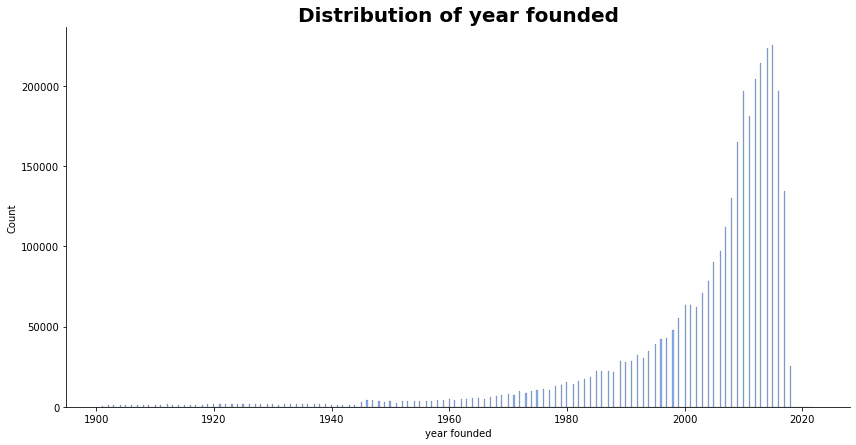

In [59]:
df.drop(df.index[df['year founded'] > 2022], inplace=True)

# distribution of companies founded after 1900
plot_distribution(df[df['year founded'] > 1900], 'year founded')

### Industry

In [60]:
# unique value counts
counts_df = df['industry'].value_counts().rename_axis('industry').reset_index(name='count')
counts_df

,industry,count
0,information technology and services,428200
1,marketing and advertising,319590
2,construction,250232
3,management consulting,185604
4,real estate,185008
...,...,...
143,fishery,2295
144,ranching,2272
145,railroad manufacture,1755
146,tobacco,1324


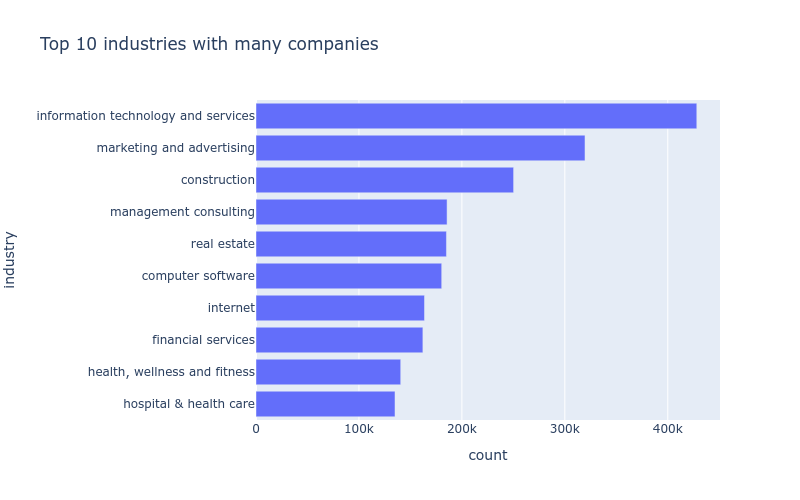

In [63]:
plotly_bar(counts_df.nlargest(10, 'count').sort_values(by='count'),\
                x_col='count', y_col='industry', title='Top 10 industries with many companies')

From the above analysis, we can see that there are 148 different industries in this dataset. The above bar plot showes the top 10 industries in the dataset.

### Size range

In [64]:
# unique value counts
counts_df = df['size range'].value_counts().rename_axis('size range').reset_index(name='count')
counts_df

,size range,count
0,1 - 10,5123118
1,11 - 50,1065972
2,51 - 200,294242
3,201 - 500,67694
4,501 - 1000,23581
5,1001 - 5000,19721
6,5001 - 10000,2259
7,10001+,1314


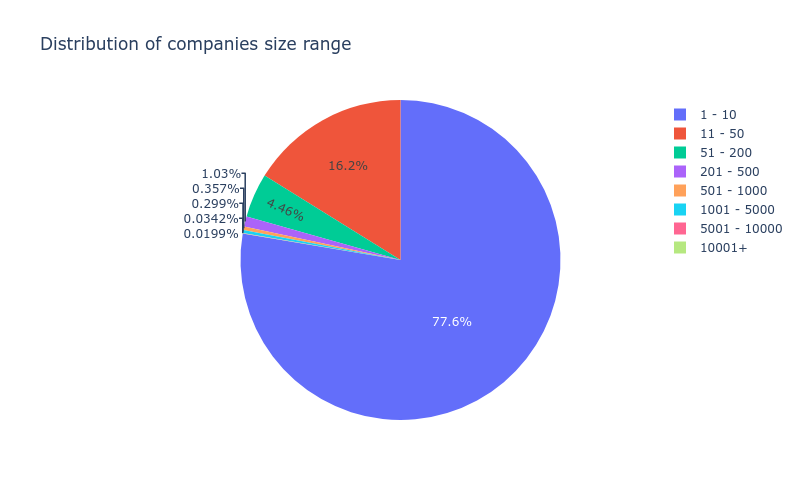

In [67]:
plotly_pie(df, col='size range', title='Distribution of companies size range')

As we can see, there are only 8 different size ranges in the dataset, and most of the companies are in the range of 1-10. This means that there are lots of small companies in the dataset, and very few large companies.

### Locality

In [69]:
# unique value counts
counts_df = df['locality'].value_counts().rename_axis('locality').reset_index(name='count')
counts_df

,locality,count
0,"london, greater london, united kingdom",81734
1,"new york, new york, united states",62181
2,"madrid, madrid, spain",55484
3,"paris, île-de-france, france",32386
4,"london, london, united kingdom",29962
...,...,...
94431,"ivychurch, kent, united kingdom",1
94432,"jarak, vojvodina, serbia",1
94433,"wegrzce wielkie, lesser poland voivodeship, po...",1
94434,"tarnovo, veliko turnovo, bulgaria",1


The data reveals a majority of the companies are located in major global cities such as London, New York, Madrid, and Paris. Interestingly, London features twice (at indices 0 and 4) with minor variations, indicating data inconsistency. We'll address this by extracting cities as a distinct feature in later stages.

### Country

In [70]:
# unique value counts
counts_df = df['country'].value_counts().rename_axis('country').reset_index(name='count')
counts_df

,country,count
0,united states,2145992
1,united kingdom,473653
2,canada,177528
3,spain,138200
4,india,135951
...,...,...
231,niue,1
232,u.s. virgin islands,1
233,norfolk island,1
234,saint pierre and miquelon,1


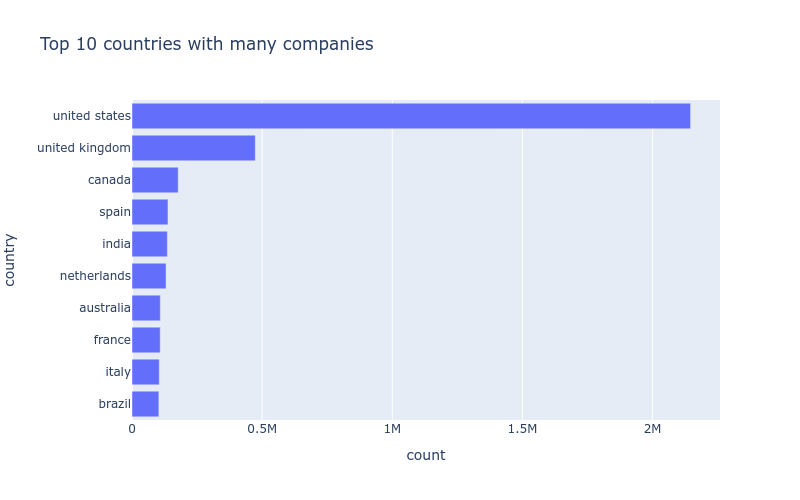

In [72]:
plotly_bar(counts_df.nlargest(10, 'count').sort_values(by='count'), \
                x_col='count', y_col='country', title='Top 10 countries with many companies')


Here, we can see that most of the companies in this dataset are from developed countries. Also, as we expect, US has the most number of companies in the dataset.

### Linkedin url

In [73]:
counts_df = df['linkedin url'].value_counts().rename_axis('linkedin url').reset_index(name='count')
counts_df

,linkedin url,count
0,linkedin.com/company/tata-consultancy-services,1
1,linkedin.com/company/american-center-of-krasnodar,1
2,linkedin.com/company/siemens,1
3,linkedin.com/company/mcdonald's-corporation,1
4,linkedin.com/company/kaiser-permanente,1
...,...,...
6597896,linkedin.com/company/medexo-robotics-ltd,1
6597897,linkedin.com/company/scottish-owl-centre,1
6597898,linkedin.com/company/grund-chiropractic-wellness,1
6597899,linkedin.com/company/stone-center-for-yoga-&-h...,1


Here, we can see that each company has its own unique LinkedIn url.

### Current employee estimate¶

In [74]:
counts_df = df['current employee estimate'].value_counts().rename_axis('current employee estimate').reset_index(name='count')
counts_df

,current employee estimate,count
0,1,2331718
1,0,1179272
2,2,926208
3,3,473327
4,4,292860
...,...,...
4482,3716,1
4483,1355,1
4484,3712,1
4485,3710,1


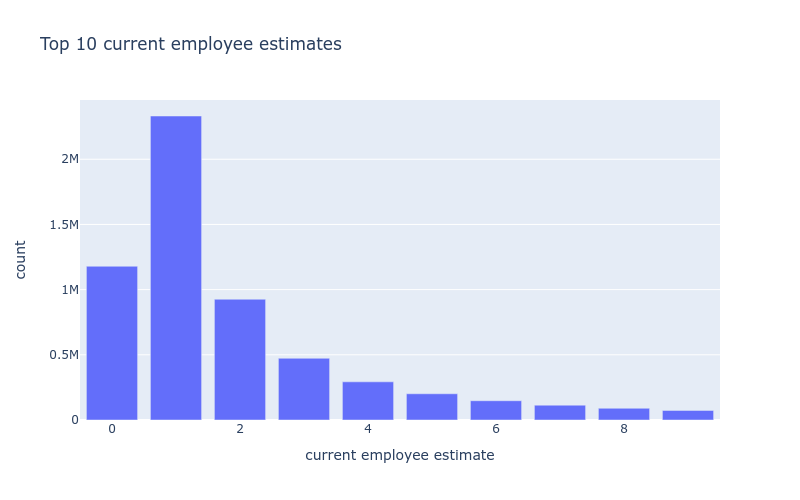

In [75]:
plotly_bar(counts_df.nlargest(10, 'count').sort_values(by='count'), \
                x_col='current employee estimate', y_col='count', title='Top 10 current employee estimates')

Our analysis appears largely accurate, except for companies displaying a '0' current employee estimate. This likely signifies unavailable data for these companies, with '0' serving as a placeholder for missing information.

## Feature Engineering

In this section, we exctract some useful features and add them to the dataset. The following list of features will be added:

- City: from the locality column, we exctract the city that the company is located at. If multiple cities were listed, we pick the first one.
- From the name column, we exctract features like: number of characters, number of digits, number of non-ascii characters, number of words, word's density, and the punctuation count.
- Also, we categorize companies' size range to make better analysis.

In [82]:
df['city'] = df['locality'].apply(extract_city)


df['name_char_count'] = df['name'].apply(lambda name: len(name))

df['name_word_count'] = df['name'].apply(lambda name: len(list(filter(lambda x: x!= '', re.split(r',|\s|-', name)))))

df['name_word_density'] = round(df['name_word_count'] / df['name_char_count'], 2)

punc = string.punctuation
df['name_punc_count'] = df['name'].apply(lambda x : len([a for a in x if a in punc]))

df['name_non_aschii_char_count'] = df['name'].apply(lambda x: len([a for a in x if ord(a) > 127]))

df['name_digit_count'] = df['name'].apply(lambda x: len([a for a in x if a in ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']]))

df['size_category'] = df['size range'].apply(categorize)

df.head(5)

,name,domain,year founded,industry,size range,locality,country,linkedin url,current employee estimate,total employee estimate,city,name_char_count,name_word_count,name_word_density,name_punc_count,name_non_aschii_char_count,name_digit_count,size_category
0,tata consultancy services,tcs.com,1968,information technology and services,10001+,"bombay, maharashtra, india",india,linkedin.com/company/tata-consultancy-services,190771,341369,bombay,25,3,0.12,0,0,0,8
1,ey,ey.com,1989,accounting,10001+,"london, greater london, united kingdom",united kingdom,linkedin.com/company/ernstandyoung,158363,428960,london,2,1,0.50,0,0,0,8
2,at&t,att.com,1876,telecommunications,10001+,"dallas, texas, united states",united states,linkedin.com/company/at&t,115188,269659,dallas,4,1,0.25,1,0,0,8
3,jpmorgan chase & co.,jpmorganchase.com,1823,financial services,10001+,"new york, new york, united states",united states,linkedin.com/company/jpmorgan-chase,95234,242135,new york,20,4,0.20,2,0,0,8
4,us navy,navy.com,0,military,10001+,"washington, district of columbia, united states",united states,linkedin.com/company/us-navy,94458,325740,washington,7,2,0.29,0,0,0,8


## Correclation Analysis

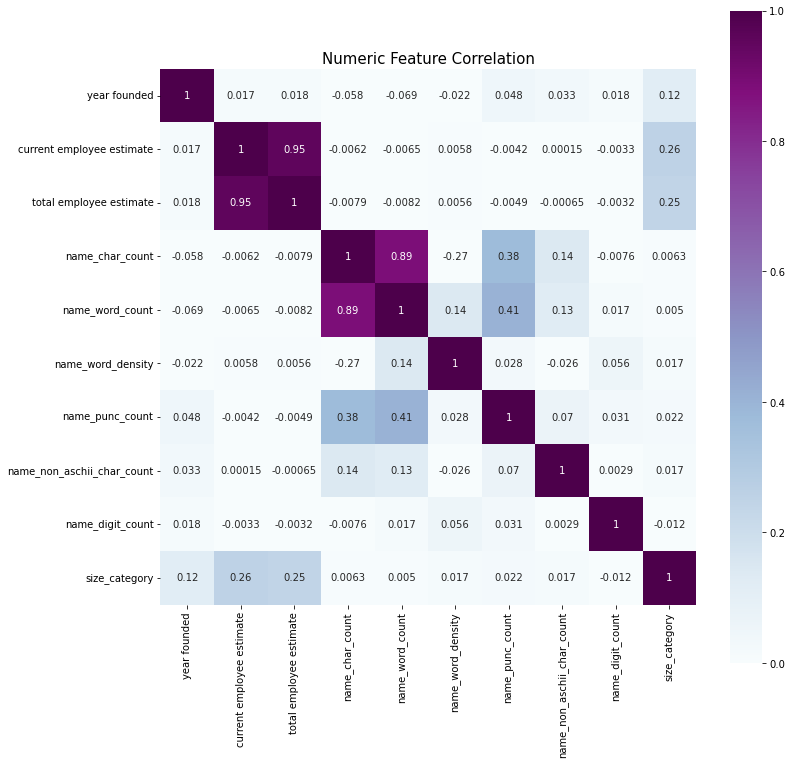

In [85]:
correlation_matrix = df.corr()
# Setting up the matplotlib figure
fig, ax = plt.subplots(figsize=(12, 12))
# Drawing the heatmap with the mask and correct aspect ratio
sns.heatmap(correlation_matrix, cmap='BuPu', vmin=0, vmax=1,
            square=True, annot=True, annot_kws={'size': 10}, ax=ax)
# Setting the title of the heatmap
ax.set_title('Numeric Feature Correlation', size=15)

plt.show()

The visualization above indicates negligible correlation amongst key numerical features. The strong correlation between 'current employee estimate' and 'total employee estimate' is expected as both essentially depict company size in terms of employees. Similarly, the engineered numeric features derived from the 'name' column exhibit correlation due to their common source. Consequently, our bivariate analysis will primarily concentrate on the interplay between non-numerical and numerical features.

## Bivariate Analysis

### Country and name_char_count

(-198.0, 198.00000000000006, -62.574678, 90.607978)

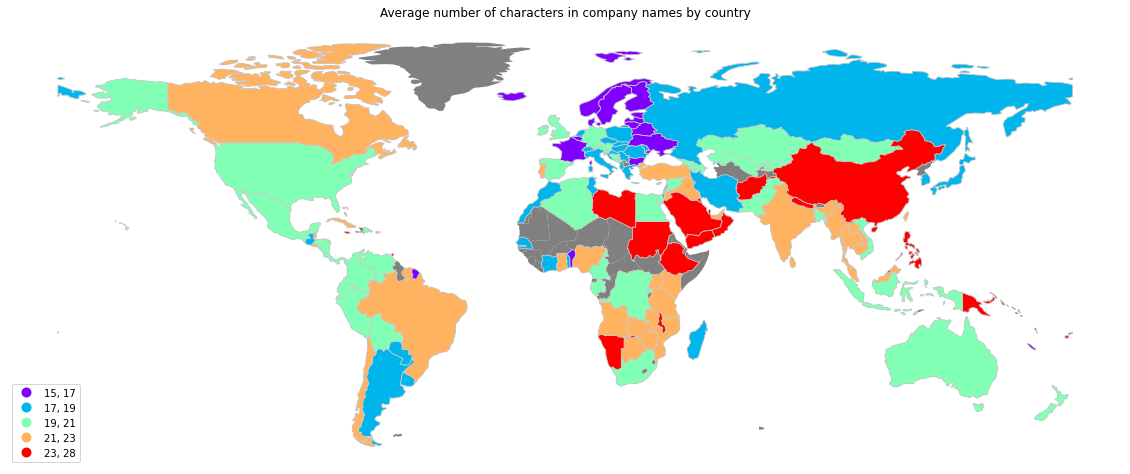

In [96]:
# Group the dataframe by 'country', calculate the mean character count and count of company names
df_country = (df.groupby('country')
              .agg(mean_name_char=('name_char_count', 'mean'), 
                   count=('name', 'size'))
              .query('count >= 100')
              .sort_values('mean_name_char', ascending=False)
              .reset_index())

# Adjust the datatypes
df_country['country'] = df_country['country'].astype('string').str.title()
df_country['mean_name_char'] = df_country['mean_name_char'].astype('int16')

# Load geopandas dataframe and subset required columns
geo_df = (gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
          .loc[:, ['name', 'geometry']]
          .rename(columns={'name': 'country'}))

# Remove Antarctica
geo_df = geo_df[geo_df['country'] != 'Antarctica']

# Country name replacements for consistency with our dataframe
country_replacements = {
    "United States of America": 'United States',
    "Bosnia and Herz.": 'Bosnia And Herzegovina',
    "Central African Rep.": 'Central African Republic',
    "Côte d'Ivoire": 'Côte D’Ivoire',
    "Dominican Rep.": 'Dominican Republic',
    "Dem. Rep. Congo": 'Democratic Republic Of The Congo',
    "Eq. Guinea": 'Equatorial Guinea',
    "Dominican Rep.": 'Dominican Republic',
    "Solomon Is.": 'Solomon Islands',
    "Trinidad and Tobago": 'Trinidad And Tobago',
    "S. Sudan": 'South Sudan',
}

geo_df['country'].replace(country_replacements, inplace=True)

# Merge grouped and geo dataframes
merged_df = geo_df.merge(df_country, on='country', how='left')

# Create a figure
fig, ax = plt.subplots(1, figsize=(20,15))

# Plot the data
merged_df.plot(color='grey', ax=ax, label = 'No data')
merged_df.dropna().plot(column='mean_name_char', cmap='rainbow', linewidth=0.8, ax=ax, edgecolor='0.8', scheme='natural_breaks', k=5, legend=True, legend_kwds={'loc': 'lower left'})

# Set the title and remove axis
plt.title('Average number of characters in company names by country')

# Adjust legend labels to display integers
legend = ax.get_legend()
for lbl in legend.get_texts():
    lbl.set_text(lbl.get_text().replace('.00', ''))
    
plt.axis('off')

Here, we examined the average number of characters in company names per countries.

### country and name_word_count

Here, we examine the relationship between country and the name_word_count. Since there is a high correlation between name_word_count and name_char_count, we expect to see similar results as the previous section.

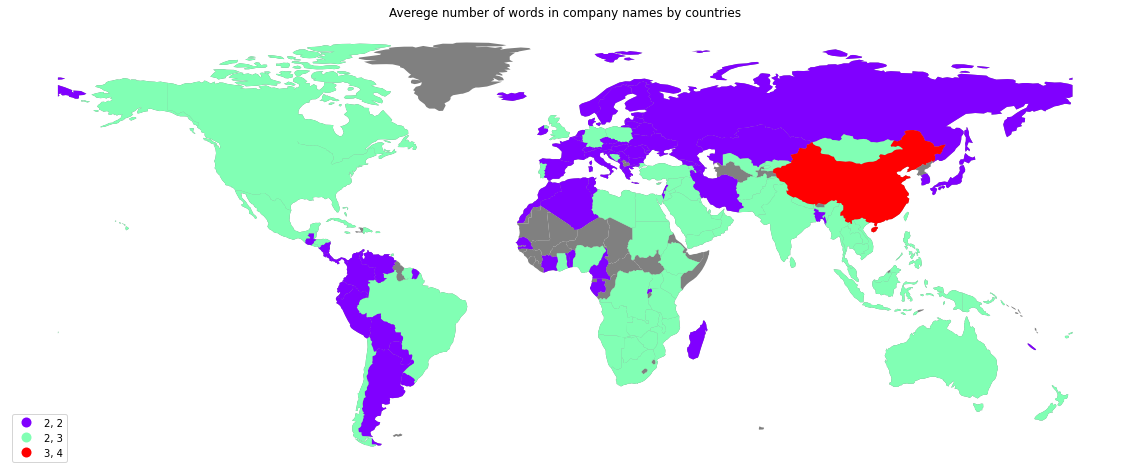

In [98]:
country_df = df.groupby('country', as_index=False).agg({'name_word_count': 'mean', 'name': 'count'}).rename(columns={'name_word_count': 'mean_name_word', 'name': 'count'})
country_df =  country_df[country_df['count'] >= 100].sort_values(by='mean_name_word',ascending=False).reset_index(drop=True)
country_df['country'] = country_df['country'].astype('string').str.title()
country_df['mean_name_word'] = country_df['mean_name_word'].astype('int16')

merged = geo_df.merge(country_df, left_on='country', right_on='country', how = 'left')

fig, ax = plt.subplots(1, figsize=(20,15))

merged.plot(color='grey', ax=ax, label = 'No data')
merged.dropna().plot(column='mean_name_word', cmap='rainbow', ax=ax, scheme='natural_breaks', k=3, legend=True, legend_kwds={'loc': 'lower left'})

plt.title('Averege number of words in company names by countries')

#fixing floating-point counts, making them integer:
leg = ax.get_legend()
for text in leg.get_texts():
    text.set_text(text.get_text().replace('.00', ''))

plt.axis('off');

The map of average character count in company names shows significant resemblance to the one illustrating average word count. It's an expected correlation since more characters typically imply more words. However, some countries demonstrate high character counts but medium word counts, suggesting a preference for longer words in their company names.

### country and name_punc_count

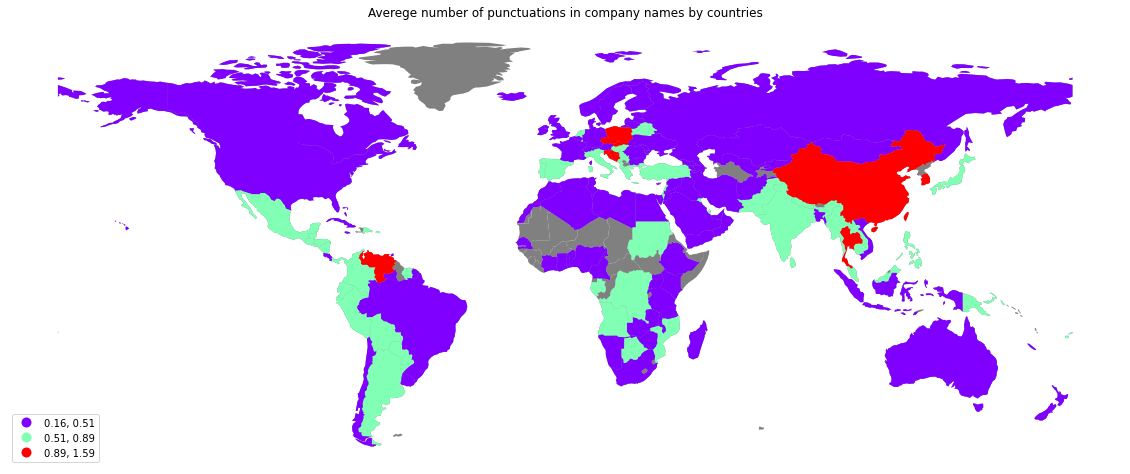

In [99]:
country_df = df.groupby('country', as_index=False).agg({'name_punc_count': 'mean', 'name': 'count'}).rename(columns={'name_punc_count': 'mean_name_punct_count', 'name': 'count'})
country_df =  country_df[country_df['count'] >= 100].sort_values(by='mean_name_punct_count',ascending=False).reset_index(drop=True)
country_df['country'] = country_df['country'].astype('string').str.title()
country_df['mean_name_punct_count'] = country_df['mean_name_punct_count'].round(2)

merged = geo_df.merge(country_df, left_on='country', right_on='country', how = 'left')

fig, ax = plt.subplots(1, figsize=(20,15))

merged.plot(color='grey', ax=ax, label = 'No data')
merged.dropna().plot(column='mean_name_punct_count', cmap='rainbow', ax=ax, scheme='natural_breaks', k=3, legend=True, legend_kwds={'loc': 'lower left'})

plt.title('Averege number of punctuations in company names by countries')

#fixing floating-point counts, making them integer:
leg = ax.get_legend()
for text in leg.get_texts():
    text.set_text(text.get_text().replace('.00', ''))

plt.axis('off');

In [100]:
country_df[country_df['mean_name_punct_count'] >= 1]

,country,mean_name_punct_count,count
0,Czechia,1.59,12085
1,Slovenia,1.49,3098
2,Slovakia,1.48,4017
3,China,1.36,35189
4,Croatia,1.20,4448
5,Venezuela,1.06,3745
6,Thailand,1.04,5398
7,Taiwan,1.04,3301
8,Bosnia And Herzegovina,1.02,945


Here, we see that some countries in europe, south east asia and south america have company names with a great chance of having a punctuation mark in their names.

### country and name_digit_count

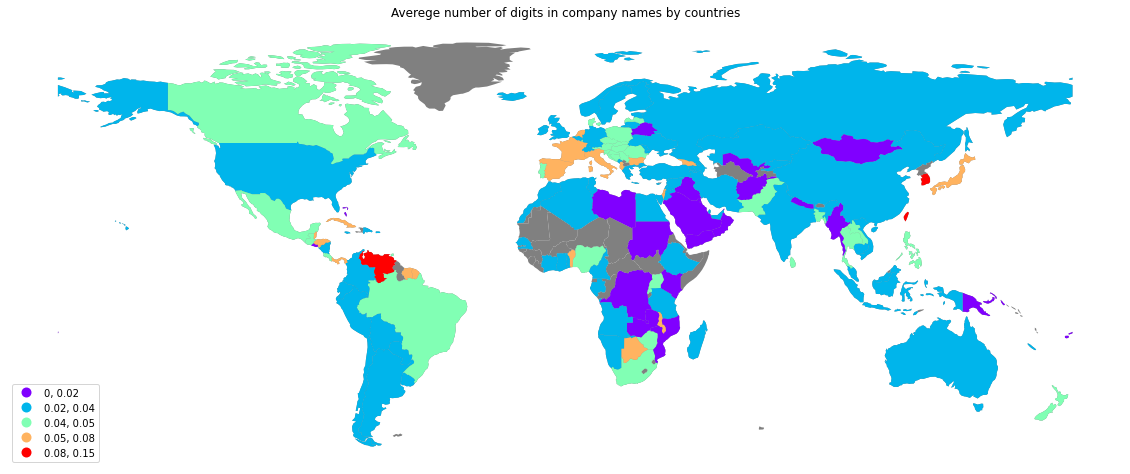

In [102]:
country_df = df.groupby('country', as_index=False).agg({'name_digit_count': 'mean', 'name': 'count'}).rename(columns={'name_digit_count': 'mean_name_digit_count', 'name': 'count'})
country_df =  country_df[country_df['count'] >= 100].sort_values(by='mean_name_digit_count',ascending=False).reset_index(drop=True)
country_df['country'] = country_df['country'].astype('string').str.title()
country_df['mean_name_digit_count'] = country_df['mean_name_digit_count'].round(2)

merged = geo_df.merge(country_df, left_on='country', right_on='country', how = 'left')

fig, ax = plt.subplots(1, figsize=(20,15))

merged.plot(color='grey', ax=ax, label = 'No data')
merged.dropna().plot(column='mean_name_digit_count', cmap='rainbow', ax=ax, scheme='natural_breaks', k=5, legend=True, legend_kwds={'loc': 'lower left'})

plt.title('Averege number of digits in company names by countries')

#fixing floating-point counts, making them integer:
leg = ax.get_legend()
for text in leg.get_texts():
    text.set_text(text.get_text().replace('.00', ''))

plt.axis('off');

In [103]:
country_df[country_df['mean_name_digit_count'] > 0.07]

,country,mean_name_digit_count,count
0,Taiwan,0.15,3301
1,Guadeloupe,0.12,165
2,South Korea,0.11,2047
3,Venezuela,0.10,3745
4,Albania,0.08,735
5,Curaçao,0.08,239


As we expect, it's not a common practice to include a digit in companies names. However, we still can see some company names with digit in their name which might be an indication of the year they were founded.

### country and name_non_aschii_char_count

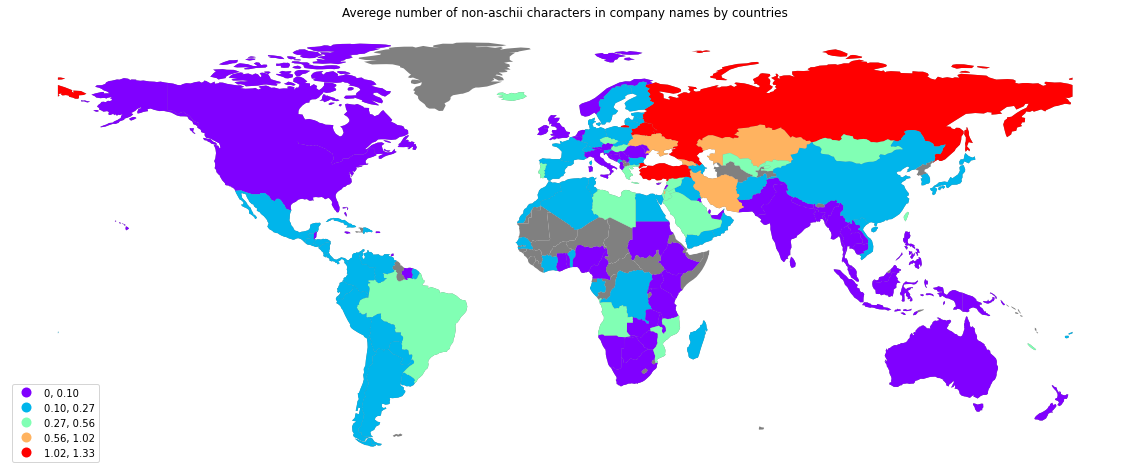

In [104]:
country_df = df.groupby('country', as_index=False).agg({'name_non_aschii_char_count': 'mean', 'name': 'count'}).rename(columns={'name_non_aschii_char_count': 'mean_name_non_aschii_char_count', 'name': 'count'})
country_df =  country_df[country_df['count'] >= 100].sort_values(by='mean_name_non_aschii_char_count',ascending=False).reset_index(drop=True)
country_df['country'] = country_df['country'].astype('string').str.title()
country_df['mean_name_non_aschii_char_count'] = country_df['mean_name_non_aschii_char_count'].round(2)

merged = geo_df.merge(country_df, left_on='country', right_on='country', how = 'left')

fig, ax = plt.subplots(1, figsize=(20,15))

merged.plot(color='grey', ax=ax, label = 'No data')
merged.dropna().plot(column='mean_name_non_aschii_char_count', cmap='rainbow', ax=ax, scheme='natural_breaks', k=5, legend=True, legend_kwds={'loc': 'lower left'})

plt.title('Averege number of non-aschii characters in company names by countries')

#fixing floating-point counts, making them integer:
leg = ax.get_legend()
for text in leg.get_texts():
    text.set_text(text.get_text().replace('.00', ''))

plt.axis('off');

In [105]:
country_df[country_df['mean_name_non_aschii_char_count'] >= 0.97]

,country,mean_name_non_aschii_char_count,count
0,Belarus,1.33,984
1,Russia,1.14,11164
2,Turkey,1.13,33898
3,Iran,1.02,6864
4,Kazakhstan,0.97,902


As we expected, most of companies with non-ascii characters in their names are from non-english speaking countries. It's also intersting for the author to see his country (Iran) in forth place :)

### country and size range

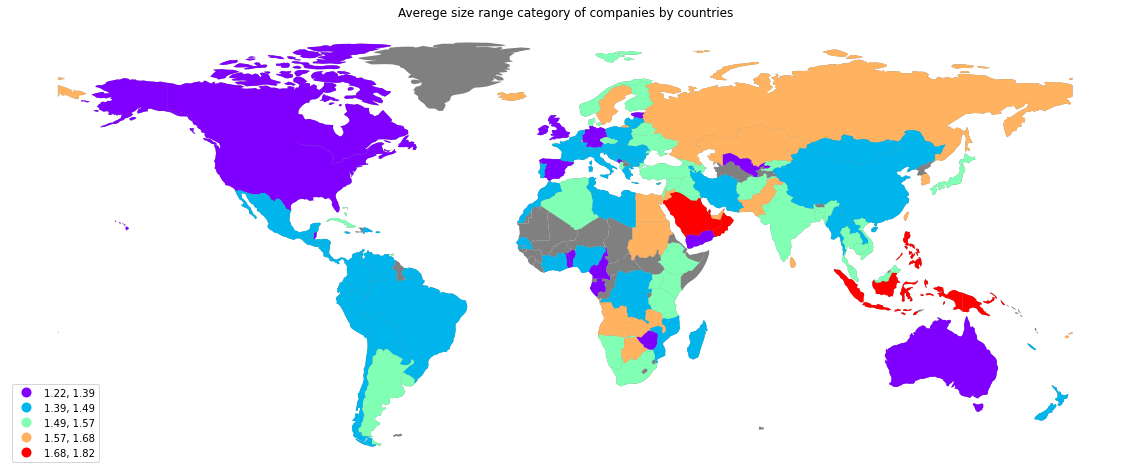

In [106]:
country_df = df.groupby('country', as_index=False).agg({'size_category': 'mean', 'name': 'count'}).rename(columns={'size_category': 'mean_size_category', 'name': 'count'})
country_df =  country_df[country_df['count'] >= 100].sort_values(by='mean_size_category',ascending=False).reset_index(drop=True)
country_df['country'] = country_df['country'].astype('string').str.title()
country_df['mean_size_category'] = country_df['mean_size_category'].round(2)

merged = geo_df.merge(country_df, left_on='country', right_on='country', how = 'left')

fig, ax = plt.subplots(1, figsize=(20,15))

merged.plot(color='grey', ax=ax, label = 'No data')
merged.dropna().plot(column='mean_size_category', cmap='rainbow', ax=ax, scheme='natural_breaks', k=5, legend=True, legend_kwds={'loc': 'lower left'})

plt.title('Averege size range category of companies by countries')

#fixing floating-point counts, making them integer:
leg = ax.get_legend()
for text in leg.get_texts():
    text.set_text(text.get_text().replace('.00', ''))

plt.axis('off');

For each country with at least 100 companies in the dataset, the average size category lies between 1.23 and 1.88. This points to a high prevalence of smaller companies, hence the lower average value.

### name and industry

Here, we want to examine what and how many companies have the name of their respective industires in their name.

In [107]:
def industry_in_name(row):
    puncs = [punc for punc in string.punctuation]
    puncs.append('and')
    industry_words = set(filter(lambda x: x not in puncs, re.split(r'\s|-', row['industry'])))
    name_words = re.split(r'\s|-', row['name'])
    return len([i for i in name_words if i in industry_words])
df['industry_word_in_name_count'] = df.apply(industry_in_name, axis=1)
name_industry_df = df[df['industry_word_in_name_count'] > 0]
name_industry_df

,name,domain,year founded,industry,size range,locality,country,linkedin url,current employee estimate,total employee estimate,city,name_char_count,name_word_count,name_word_density,name_punc_count,name_non_aschii_char_count,name_digit_count,size_category,industry_word_in_name_count
0,tata consultancy services,tcs.com,1968,information technology and services,10001+,"bombay, maharashtra, india",india,linkedin.com/company/tata-consultancy-services,190771,341369,bombay,25,3,0.12,0,0,0,8,1
45,nyc department of education,nyc.gov,0,education management,10001+,"new york, new york, united states",united states,linkedin.com/company/nyc-department-of-education,30526,45049,new york,27,4,0.15,0,0,0,8,1
80,social security administration,socialsecurity.gov,1935,government administration,10001+,"baltimore, maryland, united states",united states,linkedin.com/company/ssa,21150,28143,baltimore,30,3,0.10,0,0,0,8,1
96,lg electronics,lg.com,1947,consumer electronics,10001+,"seoul, seoul-t'ukpyolsi, south korea",south korea,linkedin.com/company/lg-electronics,19552,47846,seoul,14,2,0.14,0,0,0,8,1
104,alberta health services,albertahealthservices.ca,2008,hospital & health care,10001+,"edmonton, alberta, canada",canada,linkedin.com/company/alberta-health-services,18502,24861,edmonton,23,3,0.13,0,0,0,8,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6597877,agile4ever consulting services,agile4ever.com,2013,management consulting,1 - 10,"london, greater london, united kingdom",united kingdom,linkedin.com/company/agile4ever-consulting-ser...,0,2,london,30,3,0.10,0,0,1,1,1
6597885,grund chiropractic wellness,<NA>,0,"health, wellness and fitness",1 - 10,"santa rosa, california, united states",united states,linkedin.com/company/grund-chiropractic-wellness,0,1,santa rosa,27,3,0.11,0,0,0,1,1
6597890,nextmotion mobility engineering,nextmotion.pt,2012,mechanical or industrial engineering,1 - 10,<NA>,<NA>,linkedin.com/company/nextmotion,0,1,<NA>,31,3,0.10,0,0,0,1,1
6597898,a w hargrove insurance agency,<NA>,0,insurance,1 - 10,"exmore, virginia, united states",united states,linkedin.com/company/a-w-hargrove-insurance-ag...,0,1,exmore,29,5,0.17,0,0,0,1,1


Now that we have this subset of the original dataset, we can conduct more analysis. In the following, we will look at the relationship of these companies with their country, size range, industry and year founded.

#### industry_word_in_name_count and country

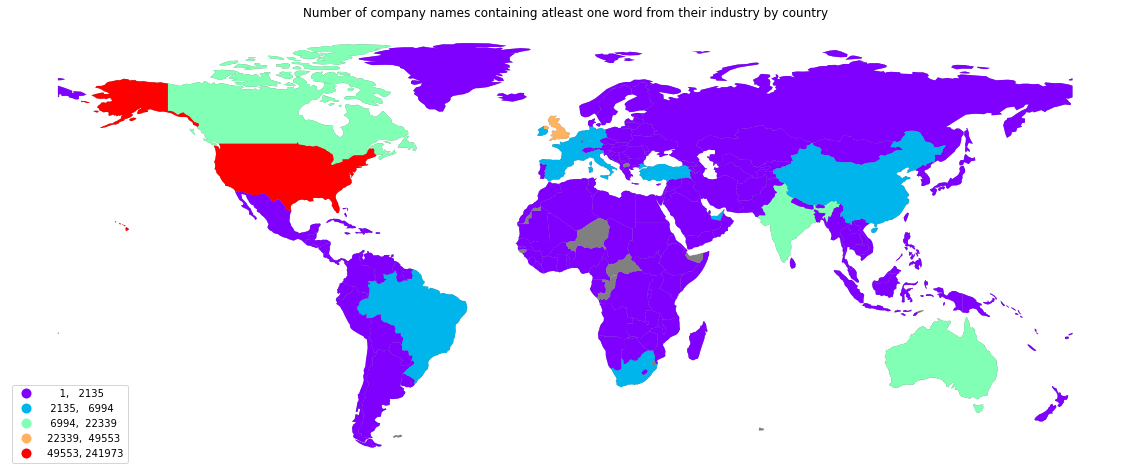

In [123]:
country_df = name_industry_df.groupby('country', as_index=False).agg({'name': 'count'}).rename(columns={'name': 'count'})
country_df =  country_df.sort_values(by='count',ascending=False).reset_index(drop=True)
country_counts_df = df['country'].value_counts().rename_axis('country').reset_index(name='total_count')
country_df = country_df.merge(country_counts_df, left_on='country', right_on='country', how = 'left')
country_df['country'] = country_df['country'].astype('string').str.title()

merged = geo_df.merge(country_df, left_on='country', right_on='country', how = 'left')
fig, ax = plt.subplots(1, figsize=(20,15))


merged.plot(color='grey', ax=ax, label = 'No data')
merged.dropna().plot(column='count', cmap='rainbow', ax=ax, scheme='natural_breaks', k=5, legend=True, legend_kwds={'loc': 'lower left'})

plt.title('Number of company names containing atleast one word from their industry by country')

#fixing floating-point counts, making them integer:
leg = ax.get_legend()
for text in leg.get_texts():
    text.set_text(text.get_text().replace('.00', ''))

plt.axis('off');


In [126]:
country_df['percent'] = country_df['count']/country_df['total_count']
country_df.sort_values(['percent'], ascending=False).query('total_count >= 10000').head(10)

,country,count,total_count,percent
12,United Arab Emirates,3356,20523,0.163524
2,Canada,22339,177528,0.125834
15,Ireland,2393,19246,0.124338
10,China,4321,35189,0.122794
13,South Africa,3038,25347,0.119856
4,Australia,12954,108841,0.119018
17,New Zealand,2135,18343,0.116393
0,United States,241973,2145992,0.112756
26,Greece,1151,10436,0.110291
1,United Kingdom,49553,473653,0.104619


As we can see from the map above, the US has the most number of companies with an industry-related word in their name. This is an interesting finding, but the underlying reason might be that a large number of companies in this data set are from US (as depicted before in the univariate analysis of the country column). Thus, we cannot conclude with a high certainty that companies in the US have a tendancy to put an industry word in their name.

However, if we filter out countries that have more than 10000 companies and then look at the percentage of the companies with an industry related word in them, we can see that UAE and Canada take a higher place. From this, it's safe to conclude that in these countries there is a tendancy for the companies to include a industry related word in their name.

#### industry_word_in_name_count and size range

In [127]:
size_df = name_industry_df.groupby('size range', as_index=False).agg({'name': 'count'}).rename(columns={'name': 'count'})
size_counts_df = df['size range'].value_counts().rename_axis('size range').reset_index(name='total_count')
size_df = size_df.merge(size_counts_df, left_on='size range', right_on='size range', how = 'left')
size_df =  size_df.sort_values(by='count',ascending=False).reset_index(drop=True)
size_df['percent'] = size_df['count']/size_df['total_count']
size_df

,size range,count,total_count,percent
0,1 - 10,473408,5123118,0.092406
1,11 - 50,96017,1065972,0.090075
2,51 - 200,25381,294242,0.086259
3,201 - 500,5862,67694,0.086596
4,501 - 1000,2078,23581,0.088122
5,1001 - 5000,1769,19721,0.089701
6,5001 - 10000,216,2259,0.095618
7,10001+,107,1314,0.081431


From the above table, we can see that more companies with smaller size tend to have an industry name in their name. However, once we consider the percentage, we can see that there isn't a significant connection. Thus, we cannot conclude anything with certainty.

#### industry_word_in_name_count and industry

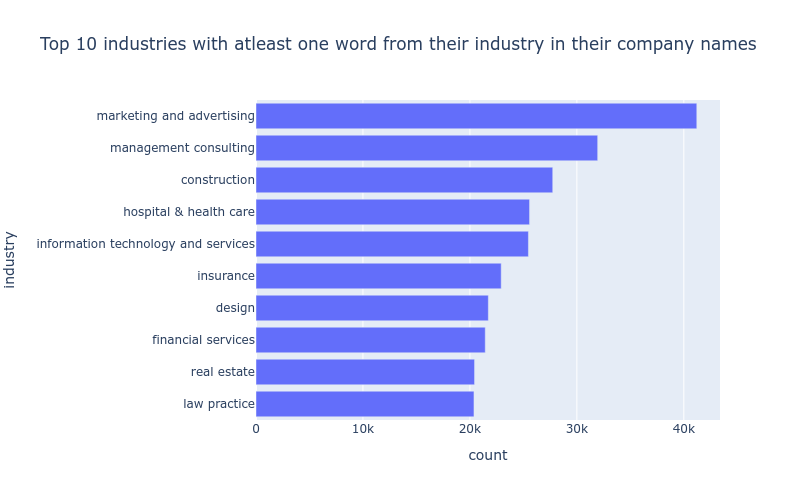

In [129]:
industry_df = name_industry_df.groupby('industry', as_index=False).agg({'name': 'count'}).rename(columns={'name': 'count'})
industry_counts_df = df['industry'].value_counts().rename_axis('industry').reset_index(name='total_count')
industry_df = industry_df.merge(industry_counts_df, left_on='industry', right_on='industry', how = 'left')
industry_df =  industry_df.sort_values(by='count',ascending=False).reset_index(drop=True)
plotly_bar(industry_df.nlargest(10, 'count').sort_values(by='count'), \
           x_col='count', y_col='industry', title='Top 10 industries with atleast one word from their industry in their company names')


The bar chart plotted above shows top 10 industries with words from their respective industry in their company names.

#### industry_word_in_name_count and year founded

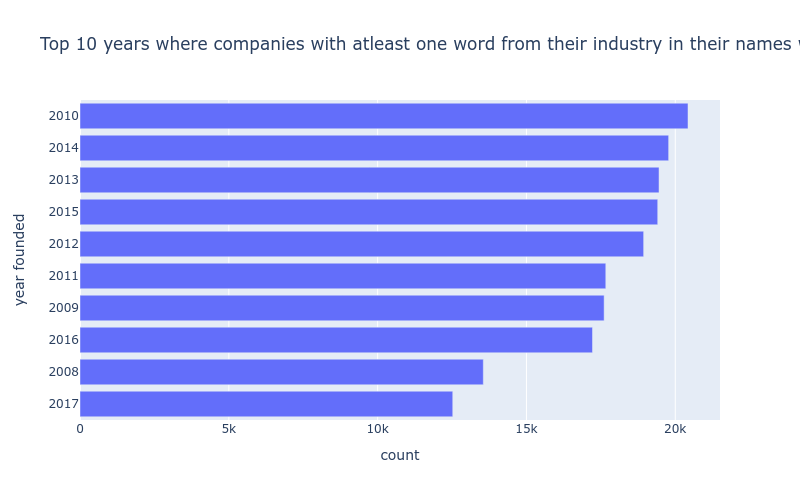

In [130]:
year_df = name_industry_df.groupby('year founded', as_index=False).agg({'name': 'count'}).rename(columns={'name': 'count'})
year_df = year_df[year_df['year founded'] != 0]
year_counts_df = df['year founded'].value_counts().rename_axis('year founded').reset_index(name='total_count')
year_df = year_df.merge(year_counts_df, left_on='year founded', right_on='year founded', how = 'left')
year_df =  year_df.sort_values(by='count',ascending=False).reset_index(drop=True)
year_df['year founded'] = year_df['year founded'].astype('string')

plotly_bar(year_df.nlargest(10, 'count').sort_values(by='count'),\
                x_col='count', y_col='year founded', title='Top 10 years where companies with atleast one word from their industry in their names were founded')

### Name and locality

Similar to name and the industry in the previous section, in this section, we perform an analysis on name and locality.

In [132]:
df['locality_word_in_name_count'] = df.apply(locality_in_name, axis=1)
name_locality_df = df[df['locality_word_in_name_count'] > 0]
name_locality_df.head(5)

,name,domain,year founded,industry,size range,locality,country,linkedin url,current employee estimate,total employee estimate,city,name_char_count,name_word_count,name_word_density,name_punc_count,name_non_aschii_char_count,name_digit_count,size_category,industry_word_in_name_count,locality_word_in_name_count
8,department of veterans affairs,va.gov,1930,government administration,10001+,"washington, district of columbia, united states",united states,linkedin.com/company/department-of-veterans-af...,62685,86489,washington,30,4,0.13,0,0,0,8,0,1.0
56,saudi aramco,saudiaramco.com,1933,oil & energy,10001+,"dhahran, eastern province, saudi arabia",saudi arabia,linkedin.com/company/saudi-aramco,27631,40870,dhahran,12,2,0.17,0,0,0,8,0,1.0
63,united states department of defense,defense.gov,1947,military,10001+,"washington, district of columbia, united states",united states,linkedin.com/company/united-states-department-...,26000,50520,washington,35,5,0.14,0,0,0,8,0,3.0
87,los angeles unified school district,lausd.net,1853,education management,10001+,"los angeles, california, united states",united states,linkedin.com/company/los-angeles-unified-schoo...,20404,30115,los angeles,35,5,0.14,0,0,0,8,0,1.0
95,emirates,emirates.com,1985,airlines/aviation,10001+,"dubai, dubai, united arab emirates",united arab emirates,linkedin.com/company/emirates,19657,33168,dubai,8,1,0.12,0,0,0,8,0,1.0


#### locality_word_in_name_count and country

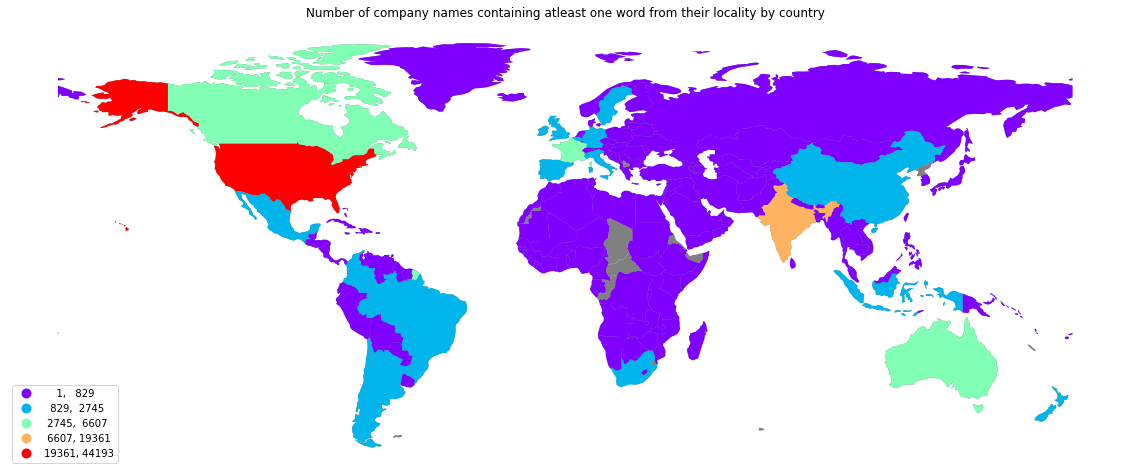

In [133]:
country_df = name_locality_df.groupby('country', as_index=False).agg({'name': 'count'}).rename(columns={'name': 'count'})
country_df =  country_df.sort_values(by='count',ascending=False).reset_index(drop=True)
country_counts_df = df['country'].value_counts().rename_axis('country').reset_index(name='total_count')
country_df = country_df.merge(country_counts_df, left_on='country', right_on='country', how = 'left')
country_df['country'] = country_df['country'].astype('string').str.title()

merged = geo_df.merge(country_df, left_on='country', right_on='country', how = 'left')

fig, ax = plt.subplots(1, figsize=(20,15))

merged.plot(color='grey', ax=ax, label = 'No data')
merged.dropna().plot(column='count', cmap='rainbow', ax=ax, scheme='natural_breaks', k=5, legend=True, legend_kwds={'loc': 'lower left'})

plt.title('Number of company names containing atleast one word from their locality by country')

#fixing floating-point counts, making them integer:
leg = ax.get_legend()
for text in leg.get_texts():
    text.set_text(text.get_text().replace('.00', ''))

plt.axis('off');

In [136]:
country_df['percent'] = country_df['count']/country_df['total_count']
country_df.sort_values(['percent'], ascending=False).query('total_count >= 10000').head(10)

,country,count,total_count,percent
7,Indonesia,2133,14402,0.148104
1,India,19361,135951,0.142412
9,Chile,1929,20223,0.095386
10,South Africa,1722,25347,0.067937
16,Colombia,1136,16758,0.067789
12,Argentina,1537,23396,0.065695
29,Malaysia,669,10647,0.062835
2,Australia,6607,108841,0.060703
17,Ireland,1134,19246,0.058921
26,Romania,723,12414,0.058241


Similar to the previous section, we see that in the map there are more companies with a locality-related word in their name in the US. However, when we focus on the percentage and just keep the countries with at least 10000 companies, we see that Indonesia and India take the majority. Here, we can conclude that companies in these countries tend to put a sign of their locality in their name.

#### locality_word_in_name_count and size range

In [139]:
size_df = name_locality_df.groupby('size range', as_index=False).agg({'name': 'count'}).rename(columns={'name': 'count'})
size_counts_df = df['size range'].value_counts().rename_axis('size range').reset_index(name='total_count')
size_df = size_df.merge(size_counts_df, left_on='size range', right_on='size range', how = 'left')
size_df =  size_df.sort_values(by='count',ascending=False).reset_index(drop=True)
size_df['percent'] = size_df['count']/size_df['total_count']*100
size_df

,size range,count,total_count,percent
0,1 - 10,91297,5123118,1.782059
1,11 - 50,28301,1065972,2.654948
2,51 - 200,10534,294242,3.580046
3,201 - 500,2966,67694,4.381481
4,501 - 1000,1218,23581,5.165175
5,1001 - 5000,1107,19721,5.613306
6,5001 - 10000,131,2259,5.799026
7,10001+,80,1314,6.08828


Here, we see an interesting result. Almost 6% of the large companies in this dataset have a locality word in their name. Also, we can see an acsending behaviour in the percentage column. This might suggest a correlation between having a locality in the company name and its size (i.e. its probability to grow). However, we need to perform furthur analysis to reach a definitive conclution.

#### locality_word_in_name_count and industry

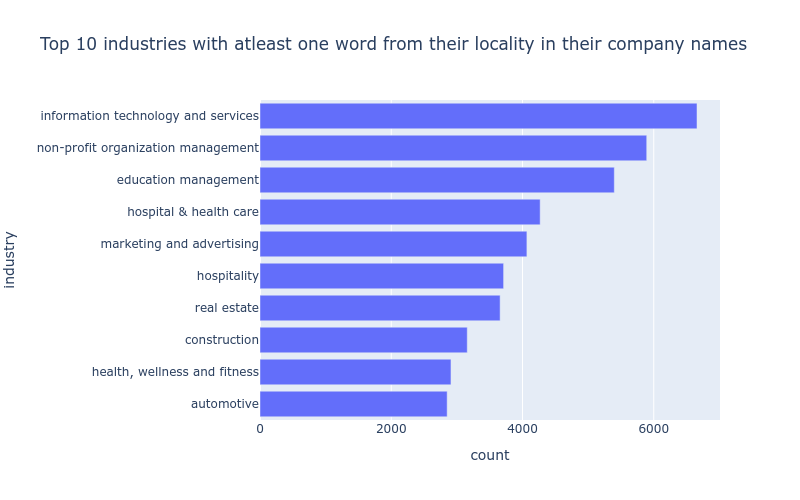

In [140]:
industry_df = name_locality_df.groupby('industry', as_index=False).agg({'name': 'count'}).rename(columns={'name': 'count'})
industry_counts_df = df['industry'].value_counts().rename_axis('industry').reset_index(name='total_count')
industry_df = industry_df.merge(industry_counts_df, left_on='industry', right_on='industry', how = 'left')
industry_df =  industry_df.sort_values(by='count',ascending=False).reset_index(drop=True)
plotly_bar(industry_df.nlargest(10, 'count').sort_values(by='count'), \
                x_col='count', y_col='industry', title='Top 10 industries with atleast one word from their locality in their company names')


In [143]:
industry_df['percent'] = industry_df['count']/industry_df['total_count']*100
industry_df.sort_values(['percent'], ascending=False).query('total_count >= 1').head(10)

,industry,count,total_count,percent
12,government administration,2637,31650,8.331754
90,libraries,390,4887,7.980356
59,law enforcement,704,9116,7.722685
13,religious institutions,2176,28202,7.715765
1,non-profit organization management,5893,94613,6.228531
66,public safety,620,10822,5.72907
19,civic & social organization,1764,33233,5.307977
76,government relations,498,9426,5.283259
93,public policy,340,6892,4.933256
79,museums and institutions,479,9856,4.859984


The above plot shows that the IT related companies have more localy word in their names. This is mostly because most of the companies in this dataset are from IT industry. Once we convert it to the percentage, we can see that government related companies are the onces that have more conditional probability of containing a locality word.

#### locality_word_in_name_count and year founded

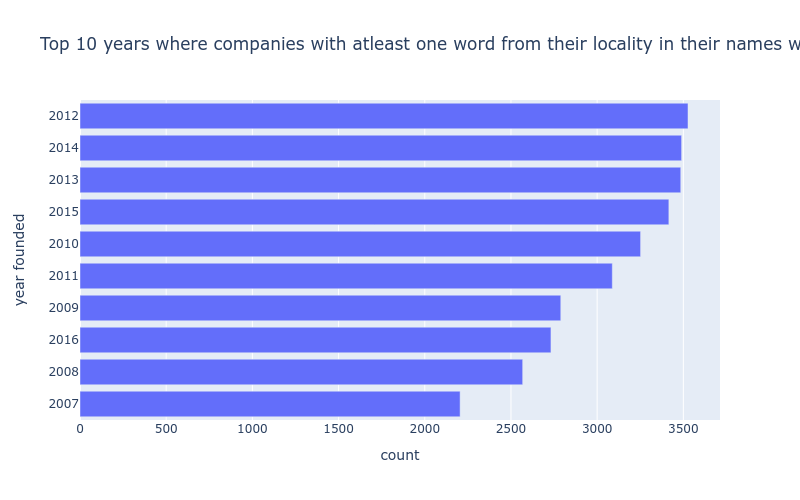

In [144]:
year_df = name_locality_df.groupby('year founded', as_index=False).agg({'name': 'count'}).rename(columns={'name': 'count'})
year_df = year_df[year_df['year founded'] != 0]
year_counts_df = df['year founded'].value_counts().rename_axis('year founded').reset_index(name='total_count')
year_df = year_df.merge(year_counts_df, left_on='year founded', right_on='year founded', how = 'left')
year_df =  year_df.sort_values(by='count',ascending=False).reset_index(drop=True)
year_df['year founded'] = year_df['year founded'].astype('string')
plotly_bar(year_df.nlargest(10, 'count').sort_values(by='count'),\
           x_col='count', y_col='year founded', title='Top 10 years where companies with atleast one word from their locality in their names were founded')



### name and year founded

Here, we do the same analysis as before between name and the year founded

In [145]:
df['year_in_name'] = df.apply(year_in_name, axis=1).astype('bool').astype('int16')
name_year_df = df[df['year_in_name'] > 0]
name_year_df.head(5)

,name,domain,year founded,industry,size range,locality,country,linkedin url,current employee estimate,total employee estimate,...,name_char_count,name_word_count,name_word_density,name_punc_count,name_non_aschii_char_count,name_digit_count,size_category,industry_word_in_name_count,locality_word_in_name_count,year_in_name
24611,ajb bumiputera 1912,bumiputera.com,1912,insurance,1001 - 5000,"jakarta, jakarta raya, indonesia",indonesia,linkedin.com/company/ajb-bumiputera-1912,374,625,...,19,3,0.16,0,0,4,6,0,0.0,1
36083,peapack-gladstone bank private banking since 1921,pgbank.com,1921,banking,501 - 1000,"bedminster, new jersey, united states",united states,linkedin.com/company/peapack-gladstone-bank,257,435,...,49,7,0.14,1,0,4,5,1,0.0,1
55441,the car finance company (2007) limited,thecarfinancecompany.co.uk,2007,financial services,201 - 500,"hampshire, hampshire, united kingdom",united kingdom,linkedin.com/company/the-car-finance-company-2...,167,315,...,38,6,0.16,2,0,4,4,0,0.0,1
57497,fabbri 1905,fabbri1905.com,1905,food & beverages,201 - 500,"bologna, emilia-romagna, italy",italy,linkedin.com/company/fabbri-1905,161,349,...,11,2,0.18,0,0,4,4,0,0.0,1
59030,altrak 1978,altrak1978.co.id,1978,machinery,201 - 500,"jakarta, jakarta raya, indonesia",indonesia,linkedin.com/company/altrak-1978,157,309,...,11,2,0.18,0,0,4,4,0,0.0,1


#### year_in_name and country

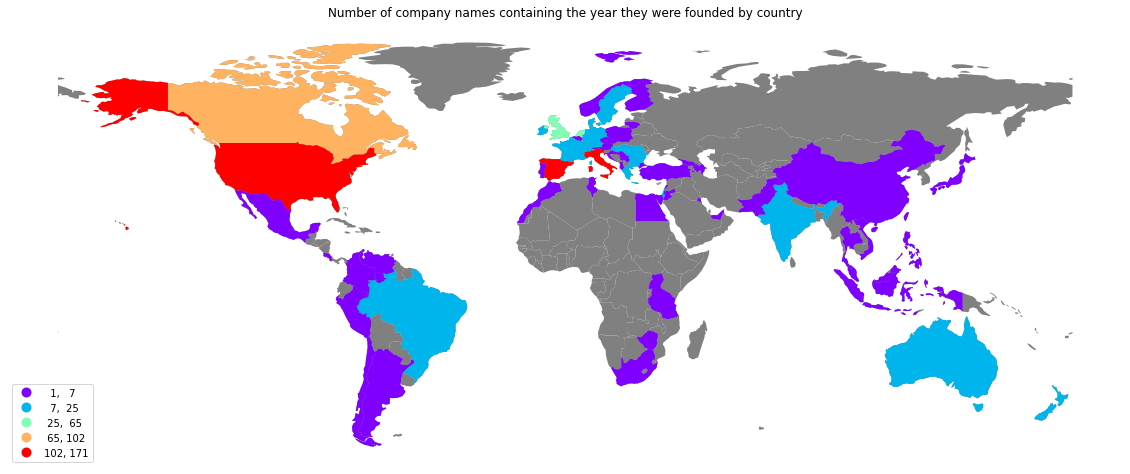

In [146]:
country_df = name_year_df.groupby('country', as_index=False).agg({'name': 'count'}).rename(columns={'name': 'count'})
country_df =  country_df.sort_values(by='count',ascending=False).reset_index(drop=True)
country_counts_df = df['country'].value_counts().rename_axis('country').reset_index(name='total_count')
country_df = country_df.merge(country_counts_df, left_on='country', right_on='country', how = 'left')
country_df['country'] = country_df['country'].astype('string').str.title()

merged = geo_df.merge(country_df, left_on='country', right_on='country', how = 'left')
fig, ax = plt.subplots(1, figsize=(20,15))

merged.plot(color='grey', ax=ax, label = 'No data')
merged.dropna().plot(column='count', cmap='rainbow', ax=ax, scheme='natural_breaks', k=5, legend=True, legend_kwds={'loc': 'lower left'})

plt.title('Number of company names containing the year they were founded by country')

#fixing floating-point counts, making them integer:
leg = ax.get_legend()
for text in leg.get_texts():
    text.set_text(text.get_text().replace('.00', ''))

plt.axis('off');

#### year_in_name and size range

In [147]:
size_df = name_year_df.groupby('size range', as_index=False).agg({'name': 'count'}).rename(columns={'name': 'count'})
size_counts_df = df['size range'].value_counts().rename_axis('size range').reset_index(name='total_count')
size_df = size_df.merge(size_counts_df, left_on='size range', right_on='size range', how = 'left')
size_df =  size_df.sort_values(by='count',ascending=False).reset_index(drop=True)
size_df

,size range,count,total_count
0,1 - 10,896,5123118
1,11 - 50,288,1065972
2,51 - 200,63,294242
3,201 - 500,14,67694
4,1001 - 5000,1,19721
5,501 - 1000,1,23581


From the results, companies whose names include their founding year often have fewer employees, although this simply mirrors the overall size distribution. Thus, a specific correlation doesn't appear to be present.

#### year_in_name and industry

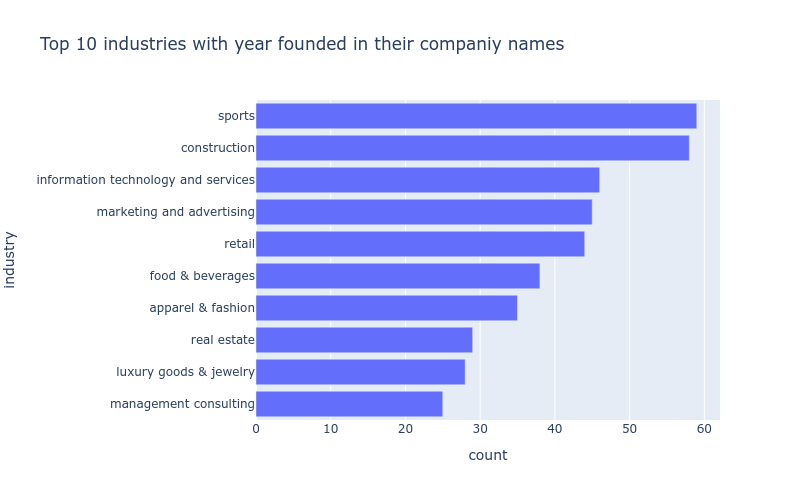

In [148]:
industry_df = name_year_df.groupby('industry', as_index=False).agg({'name': 'count'}).rename(columns={'name': 'count'})
industry_counts_df = df['industry'].value_counts().rename_axis('industry').reset_index(name='total_count')
industry_df = industry_df.merge(industry_counts_df, left_on='industry', right_on='industry', how = 'left')
industry_df =  industry_df.sort_values(by='count',ascending=False).reset_index(drop=True)
plotly_bar(industry_df.nlargest(10, 'count').sort_values(by='count'),\
                x_col='count', y_col='industry', title='Top 10 industries with year founded in their companiy names')

The above bar chart displays the top 10 industries whose company names include their founding year. Interestingly, sports companies often associate with their founding year, as demonstrated in the chart and table. Despite the smaller number of sports companies in the dataset, this industry leads in the frequency of company names referencing their year of establishment.

#### year_in_name and year founded

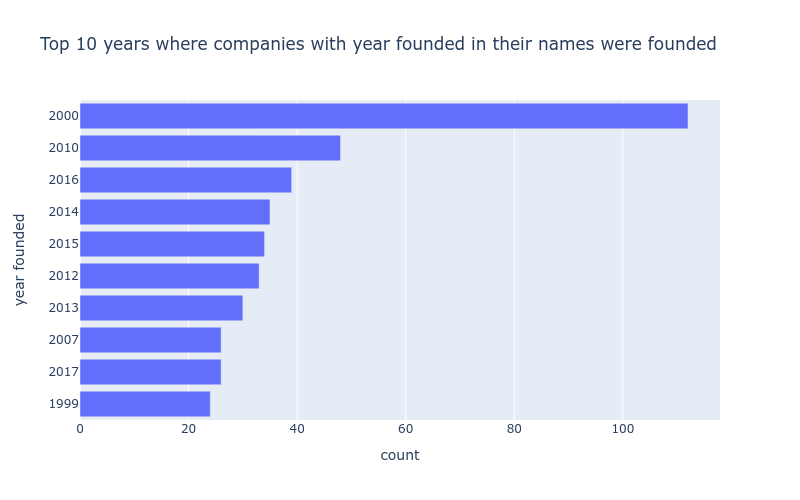

In [149]:
year_df = name_year_df.groupby('year founded', as_index=False).agg({'name': 'count'}).rename(columns={'name': 'count'})
year_counts_df = df['year founded'].value_counts().rename_axis('year founded').reset_index(name='total_count')
year_df = year_df.merge(year_counts_df, left_on='year founded', right_on='year founded', how = 'left')
year_df =  year_df.sort_values(by='count',ascending=False).reset_index(drop=True)
year_df['year founded'] = year_df['year founded'].astype('string')

plotly_bar(year_df.nlargest(10, 'count').sort_values(by='count'),\
           x_col='count', y_col='year founded', title='Top 10 years where companies with year founded in their names were founded')


Despite a comparatively smaller dataset representation, companies founded in the year 2000 lead in referencing their founding year in their names. This could be attributed to the significance of the year 2000, marking the onset of a new millennium - a unique occurrence every thousand years.

# Answeirng some Questions

In this section, we try to ask some interesting and insightful questions from the dataset, and try to answer them.

### Which words are the most common in company names of each industry?

In [150]:
industries = df['industry'].unique()
industry_name_words_dict = {}

for industry in industries:
    industry_df = df[df['industry'] == industry]
    text = " ".join(industry_df.name)
    word_list = re.split(r'\s|-', text)
    word_list = list(filter(None, word_list))  # filtering out empty strings
    common_words = [pair[0] for pair in Counter(word_list).most_common(50)]
    industry_name_words_dict[industry] = common_words

all_words = sum(industry_name_words_dict.values(), [])  # flattening the list of lists
common_words = [word for word, count in Counter(all_words).items() if count > 20]

words_to_be_removed = set(common_words + list(string.punctuation) + list(STOPWORDS))

for industry, words in industry_name_words_dict.items():
    industry_name_words_dict[industry] = [word for word in words if word not in words_to_be_removed]

In [153]:
industry_name_words_dict['telecommunications']

['communications',
 'telecom',
 'networks',
 'mobile',
 'communication',
 'wireless',
 'telecommunications',
 'telephone',
 'communications,',
 'data',
 'cable',
 'call']

In [157]:
# A function to see what industries containt a specific word
def search_industry(word):
    industries_list = []
    for (industry, words) in industry_name_words_dict.items():
        if word in words:
            industries_list.append(industry)
    return industries_list

In [158]:
search_industry('software')

['information technology and services',
 'internet',
 'information services',
 'computer software',
 'computer games',
 'computer & network security',
 'program development']

### Which words are the most common in company names of each country?

In [159]:
countries = df['country'].unique()
country_name_words_dict = {}

for country in countries:
    country_df = df[df['country'] == country]
    text = " ".join(country_df.name)
    word_list = re.split(r'\s|-', text)
    word_list = list(filter(None, word_list))  # filtering out empty strings
    common_words = [pair[0] for pair in Counter(word_list).most_common(50)]
    country_name_words_dict[country] = common_words

all_words = sum(country_name_words_dict.values(), [])  # flattening the list of lists
common_words = [word for word, count in Counter(all_words).items() if count > 20]

words_to_be_removed = set(common_words + list(string.punctuation) + list(STOPWORDS))

for country, words in country_name_words_dict.items():
    country_name_words_dict[country] = [word for word in words if word not in words_to_be_removed]

In [160]:
country_name_words_dict['canada']

['inc',
 'canada',
 'canadian',
 'health',
 'corp.',
 'toronto',
 'products',
 'society',
 'productions',
 'creative']

In [161]:
def search_country(word):
    countries_list = []
    for (country, words) in country_name_words_dict.items():
        if word in words:
            countries_list.append(country)
    return countries_list

In [164]:
search_country('health')

['united states',
 'canada',
 'australia',
 'ireland',
 'new zealand',
 'nigeria',
 'puerto rico',
 'uganda',
 'cayman islands',
 'ghana',
 'gibraltar',
 'guam',
 'malawi',
 'rwanda',
 'greenland',
 'swaziland']

# Conclution

- Words related to company structure (like pvt, ltd, limited, llc, co, inc, group, and gmbh) are most common in company names.
- Names often contain country or industry terms, and some companies include single character abbreviations.
- Over 93% of the companies employ 50 or fewer people.
- Companies are predominantly located in major cities of developed countries.
- Chinese company names tend to have more characters and words compared to others.
- A select group of countries, including Czechia, Slovenia, Slovakia, China, Croatia, among others, have a high number of punctuation marks in their company names.
- Similarly, Taiwan, Guadeloupe, South Korea, Venezuela, Albania, and Curaçao have a high occurrence of digits in company names.
- Belarus, Russia, Turkey, Iran, and Kazakhstan commonly use non-ascii characters in their company names.
- The US, UK, Canada, India, and Australia have many companies whose names include industry-related words.
- Similarly, companies often include words related to their locality in their names, especially in countries like the US, India, Australia, Canada, and France.
- Industries like sports, construction, IT, marketing, and retail often have company names containing the year they were founded.
- The years 2000, 2010, 2016, 2014, and 2015 saw the highest number of companies with names including their founding year.